<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/Faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=c245f4bb-b9a7-4311-9d2d-6dc676d1bf12
To: /content/Face Mask Detection.zip
100% 417M/417M [00:05<00:00, 83.2MB/s]
Face Mask Detection.zip download complete!


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations

random.seed(1234)
idx = random.sample(range(853), 170) # 1~853중 170개

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


In [5]:
import os
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [33]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]


def generate_label(obj):

    adjust_label = 1

    if obj.find('name').text == 'with_mask':
        return 1 + adjust_label

    elif obj.find('name').text == 'mask_weared_incorrect':
        return 2 + adjust_label

    return 0 + adjust_label


def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'html.parser')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []

        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target


def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1, 2, 0)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [16]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [17]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4) # 배경까지 해서 4

model.to(device)

In [21]:
num_epochs = 5
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [22]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 50.24783706665039, time : 259.2284564971924
epoch : 2, Loss : 42.409706115722656, time : 259.4032509326935
epoch : 3, Loss : 37.11940383911133, time : 259.42424392700195
epoch : 4, Loss : 33.27423858642578, time : 259.6913139820099
epoch : 5, Loss : 30.272869110107422, time : 259.59941363334656


In [23]:
torch.save(model.state_dict(), f'model_{num_epochs}.pt')

In [ ]:
# model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

In [24]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [25]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[117.8645,   1.7490, 132.1437,  19.3248],
        [214.6286,  61.9029, 249.8303,  96.2609]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9418, 0.9291], device='cuda:0')}, {'boxes': tensor([[219.8653,  98.2463, 256.0130, 139.1042],
        [131.4480, 108.3599, 174.9852, 152.3694],
        [ 41.2908, 110.3995,  65.0880, 140.1474],
        [303.2016, 132.0554, 330.4564, 157.8743],
        [ 29.7147,  89.1168,  45.0103, 104.9747],
        [165.0262,  89.7400, 179.1669, 110.7487],
        [  1.8468, 104.7294,  20.9501, 127.0325],
        [ 82.8851,  84.2494,  94.9139,  98.5062],
        [  2.8101, 105.1924,  21.4456, 126.9745]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0'), 'scores': tensor([0.9894, 0.9851, 0.9540, 0.9305, 0.9008, 0.8889, 0.6797, 0.6689, 0.5294],
       device='cuda:0')}]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


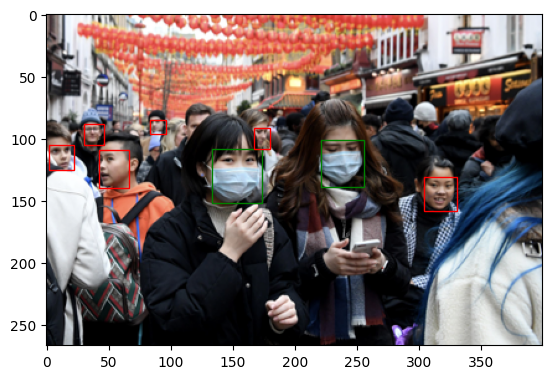

Prediction :  tensor([2, 2, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')


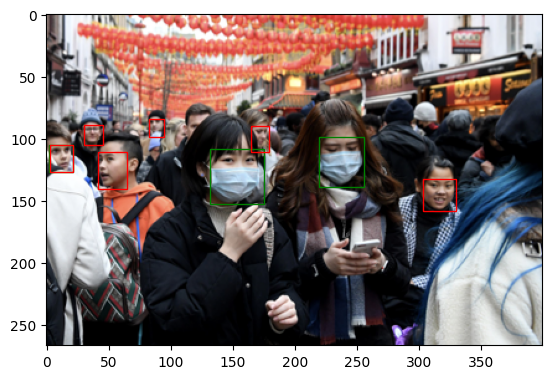

In [35]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])

pred[_idx]['boxes'] = pred[_idx]['boxes'].cpu().numpy()
pred[_idx]['labels'] = pred[_idx]['labels'].cpu().numpy()

plot_image_from_output(imgs[_idx], pred[_idx])

In [36]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:26<00:00,  3.26it/s]


In [37]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [38]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5706000079240242
AP : tensor([0.7664, 0.9454, 0.0000], dtype=torch.float64)
